In [145]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [146]:
def train_test_split_minimal(X, y, test_size=0.25, stratify=None, random_state=None):
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    # Convert to numpy arrays for easier indexing
    X, y = np.array(X), np.array(y)
    
    # Stratified split
    if stratify is not None:
        # Identify unique classes and their counts
        classes, y_indices = np.unique(y, return_inverse=True)
        train_indices = []
        test_indices = []

        for class_index in range(len(classes)):
            # Get indices of each class
            class_member_indices = np.where(y_indices == class_index)[0]
            n_test = int(len(class_member_indices) * test_size)

            # Shuffle and split for current class
            shuffled_indices = np.random.permutation(class_member_indices)
            test_indices.extend(shuffled_indices[:n_test])
            train_indices.extend(shuffled_indices[n_test:])
        
        # Final train and test sets
        train_X, test_X = X[train_indices], X[test_indices]
        train_y, test_y = y[train_indices], y[test_indices]
    
    else:
        # Non-stratified random split
        indices = np.random.permutation(len(X))
        n_test = int(len(X) * test_size)
        test_indices = indices[:n_test]
        train_indices = indices[n_test:]

        train_X, test_X = X[train_indices], X[test_indices]
        train_y, test_y = y[train_indices], y[test_indices]

    return train_X, test_X, train_y, test_y, train_indices, test_indices

def encode_y(y):
    return nn.functional.one_hot(y, CLASSES_COUNT)

# for x, y in test_loader:
#     print(x.shape, y.shape, encode_y(y).shape)

# Функция отрисовки изображений из датасета
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)
        image = to_pil_image(images[i])
        plt.imshow(image, "gray")
        plt.title(torch.argmax(labels[i]))
        plt.axis('off')
    plt.show()

# for batch_idx, (x, y) in enumerate(training_loader):
#     if batch_idx < 1:
#         show_images(x, encode_y(y))
#         break

In [147]:
TEST_PERCENT = 0.2
BATCH_SIZE = 32
TRAIN_TEST_SPLIT_RANDOM_STATE = 666
CLASSES_COUNT = 5
IMG_SIZE = 90

In [148]:
dataset = datasets.ImageFolder(
    root='dataset',
    transform=transforms.Compose([
        transforms.Grayscale(), # вместо трех каналов остается один
        transforms.ToTensor(),
    ])
)
data = np.array([item[0] for item in dataset])
labels = np.array([item[1] for item in dataset])

_, _, _, _, train_indices, test_indices = train_test_split_minimal(
    data,
    labels,
    test_size=TEST_PERCENT,
    stratify=labels,
    random_state=TRAIN_TEST_SPLIT_RANDOM_STATE
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(
    f'TOTAL: {len(dataset)}\n'
    f'TRAIN SIZE: {len(train_dataset)}\n'
    f'TEST SIZE: {len(test_dataset)}\n'
    f'CLASSES: {dataset.classes}\n' # SA SHI SU SE SO
)

TOTAL: 1400
TRAIN SIZE: 1120
TEST SIZE: 280
CLASSES: ['0', '1', '2', '3', '4']



In [149]:
import math

SIZE_OF_LAYER = [IMG_SIZE**2, 1024, 1024, 512, CLASSES_COUNT]

DEFAULT_LEARNING_RATE = 0.001
DEFAULT_LOSS_CHECK_FREQUENCY = 25
DEFAULT_EPOCH_COUNT = 24

class MyModel:
    def __init__(
            self,
            learning_rate = DEFAULT_LEARNING_RATE,
            report_frequency = DEFAULT_LOSS_CHECK_FREQUENCY
    ):
        self.report_frequency = report_frequency
        self.learning_rate = learning_rate
        self.flatten = nn.Flatten()        

        self.w1 = Parameter(nn.init.xavier_normal_(torch.FloatTensor(SIZE_OF_LAYER[0], SIZE_OF_LAYER[1])))
        self.w2 = Parameter(nn.init.xavier_normal_(torch.FloatTensor(SIZE_OF_LAYER[1], SIZE_OF_LAYER[2])))
        self.w3 = Parameter(nn.init.xavier_normal_(torch.FloatTensor(SIZE_OF_LAYER[2], SIZE_OF_LAYER[3])))
        self.w4 = Parameter(nn.init.xavier_normal_(torch.FloatTensor(SIZE_OF_LAYER[3], SIZE_OF_LAYER[4])))
        
        # self.n1 = nn.BatchNorm1d(SIZE_OF_LAYER[1])
        # self.n2 = nn.BatchNorm1d(SIZE_OF_LAYER[2])
        # self.n3 = nn.BatchNorm1d(SIZE_OF_LAYER[3])
        
    def forward(self, input):
        # print('===========> FORWARD')
        v = self.flatten(input)
        # print('v after flatten = ', v)
        
        v = torch.mm(v, self.w1)
        # print('v after w1 = ', v, '\n w1 = ', self.w1)
        
        v = torch.relu(v)
        # print('v after relu 1 = ', v)
        
        v = torch.mm(v, self.w2)
        # print('v after w2 = ', v, '\n w2 = ', self.w2)
        
        v = torch.relu(v)
        # print('v after relu 2 = ', v)
        
        v = torch.mm(v, self.w3)
        # print('v after w3 = ', v, '\n w3 = ', self.w3)
        
        v = torch.relu(v)
        # print('v after relu 3 = ', v)
    
        v = torch.mm(v, self.w4)
        # print('v after w4 = ', v, '\n w4 = ', self.w4)
        
        return v

    def train(self, x, y, iter):
        value = self.forward(x)
        h = torch.sum((y - value)**2)
        
        # if(math.isnan(h.data)):
        #     print('x = ',x)
        #     print('value = ',value)
            
        if iter % self.report_frequency == 0:
            print(f"loss: {h.data / BATCH_SIZE}")

        h.backward()

        self.w1.data -= self.learning_rate * self.w1.grad.data
        self.w2.data -= self.learning_rate * self.w2.grad.data
        self.w3.data -= self.learning_rate * self.w3.grad.data
        self.w4.data -= self.learning_rate * self.w4.grad.data

        self.w1.grad.data.zero_()
        self.w2.grad.data.zero_()
        self.w3.grad.data.zero_()
        self.w4.grad.data.zero_()

model = MyModel()
for e in range(DEFAULT_EPOCH_COUNT):
    print(f"== Epoch: {e} ==")
    for iter, (x, y) in enumerate(train_loader):
        model.train(x, encode_y(y), iter)


== Epoch: 0 ==
loss: 0.9213945865631104
loss: 0.3580901026725769
== Epoch: 1 ==
loss: 0.1735151708126068
loss: 0.11964481323957443
== Epoch: 2 ==
loss: 0.0888146162033081
loss: 0.10774725675582886
== Epoch: 3 ==
loss: 0.04784870147705078
loss: 0.05467910319566727
== Epoch: 4 ==
loss: 0.038778387010097504
loss: 0.03844373673200607
== Epoch: 5 ==
loss: 0.01675194315612316
loss: 0.027761360630393028
== Epoch: 6 ==
loss: 0.015768278390169144
loss: 0.012210281565785408
== Epoch: 7 ==
loss: 0.012816389091312885
loss: 0.010083410888910294
== Epoch: 8 ==
loss: 0.008313454687595367
loss: 0.00679900124669075
== Epoch: 9 ==
loss: 0.0055050356313586235
loss: 0.008230293169617653
== Epoch: 10 ==
loss: 0.004295360296964645
loss: 0.005884266458451748
== Epoch: 11 ==
loss: 0.005458381492644548
loss: 0.0035406923852860928
== Epoch: 12 ==
loss: 0.002177168382331729
loss: 0.004112954251468182
== Epoch: 13 ==
loss: 0.002051383024081588
loss: 0.0016329146455973387
== Epoch: 14 ==
loss: 0.001434417325071990

In [150]:
sum = 0
positive = 0
for iter, (x, y) in enumerate(test_loader):
    res = model.forward(x)
    sum += torch.sum((res - encode_y(y))**2).data
    # print(res.argmax(1), y)
    positive += (res.argmax(1) == y).type(torch.float).sum().item()
print(f"Test loss: {sum.data / len(test_indices)}, accuracy: {positive / len(test_indices)*100}%")

Test loss: 0.1557142436504364, accuracy: 97.5%


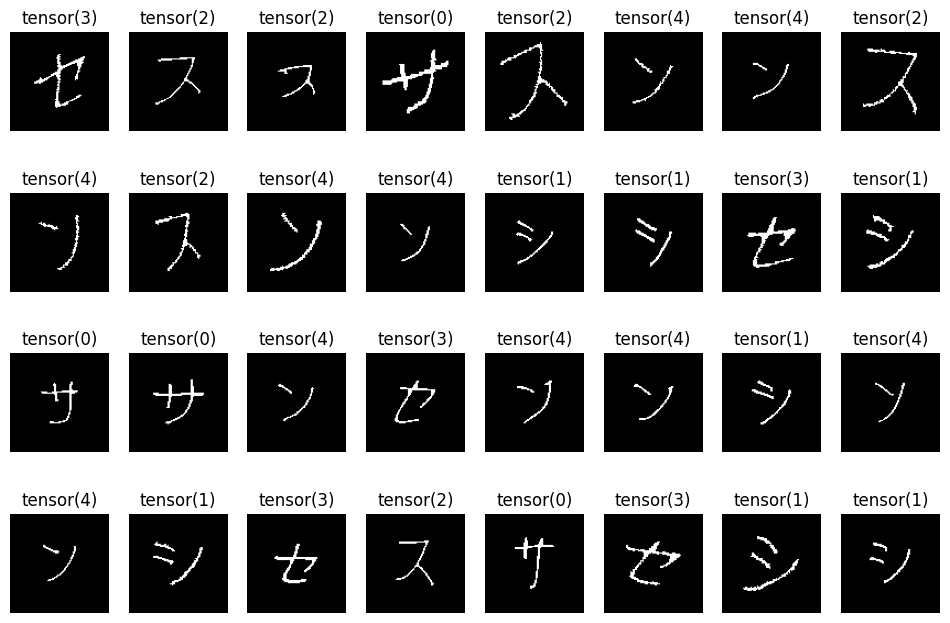

In [151]:
for batch_idx, (x, y) in enumerate(test_loader):
    if batch_idx < 1:
        show_images(x, model.forward(x).data)
        break